# Ecological Index - regional scalings
- Calculate historical and future ecological index values from CESM2-LE MARBL NPP, KGP, & FEISTY (demersal only) and penguin population projections (EP and AP).
- Notebook by Alice DuVivier (NCAR)
- Note: this notebook needs to load the utils.py file
- October 2024

In [1]:
import utils
import xarray as xr
import numpy as np
from glob import glob
import intake
import importlib
import pop_tools
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cartopy
import cartopy.crs as ccrs
import cmocean
import geopandas as gpd

## How to make ecoindex

- Verify that time (year) and spatial dimensions (lat/lon) are identical for each input
- Only interested in forced change signal, so calculating and using ensemble mean for CESM2 related inputs.
- Penguin projections are median of the future projected populations.
- Calculate ecoindex by summing all inputs. We've weighted each input equally, but could do sums of just some inputs of value (e.g. MARBL only, FEISTY + MARBL, PENGINS only).
- We'll calculate the index for each year 1950-2099, but there are concerns with noise in penguin projections. Thus, we'll also calculate decadal ecoindex values for 1960 - 2090 by averaging 5 years around the decade (e.g. 1980 --> 1978, 1979, 1980, 1981, 1982)
- Only need CCAMLR MPA regions: 1 (Peninsula), 3 (Weddell), 4 (E Weddell), 7 (E. Ant), 8 (Ross), 9 (Bellingshausen and Amundsen)
- Check and test both global and regional scaling **for the EcoIndex only** (not inputs), so each region should have an ecoindex of 1 that shows the maximum *in that region*. We want to see most valuable regions around whole continent and within regions.  This is relevant because management is done regionally by CCAMLR.
- We use maximum value to scale so that the range is 0-1 for Ecoindex. We also tried scaling by median but that didn't really change where was most valuable, just the scaling, so stick with maximum value for ease of communication.


## Load Data

### Load grid and mask data

In [2]:
# directory path
dir_in = '/glade/u/home/duvivier/masks/'

In [3]:
# load ocean grid
fin = 'ocn_grid_gx1v7.nc'
ds_grid = xr.open_mfdataset(dir_in+fin,decode_times=False)
ds_grid['nlat'] = ds_grid.nlat
ds_grid['nlon'] = ds_grid.nlon
ds_grid

# load sea ice masks
fin = 'REGION_MASK_gx1v7.nc'
ds_mask = xr.open_mfdataset(dir_in+fin,decode_times=False)
ds_mask = ds_mask.isel(time=0)
ds_mask = ds_mask.rename({'lat':'nlat','lon': 'nlon'})
ds_mask['nlat'] = ds_grid.nlat
ds_mask['nlon'] = ds_grid.nlon
ds_mask

<xarray.Dataset>
Dimensions:       (nlon: 320, nlat: 384)
Coordinates:
  * nlon          (nlon) int64 0 1 2 3 4 5 6 7 ... 313 314 315 316 317 318 319
  * nlat          (nlat) int64 0 1 2 3 4 5 6 7 ... 377 378 379 380 381 382 383
Data variables: (12/18)
    Lab_mask      (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    GIN_mask      (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    Bar_mask      (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ArcOc_mask    (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    Sib_mask      (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    Beau_mask     (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ...            ...
    Ross_mask     (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    Ind_mask      (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    Pac_mask      (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    BAm_mask      (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    nh_mask       (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    sh_mask       (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>

In [4]:
## Enter the latitudes you want to keep:
lat_min = -80
lat_max = -60

In [5]:
# crop data to the latitudes we want, use given lat/lon, not specific indices
ds_grid = ds_grid.where(((ds_grid['TLAT'] <= lat_max) & (ds_grid['TLAT'] >= lat_min)), drop=True)
ds_mask = ds_mask.where(((ds_grid['TLAT'] <= lat_max) & (ds_grid['TLAT'] >= lat_min)), drop=True)

In [6]:
# Read in 
dir_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/'
# Read in CCAMLR planning domain masks
file_in = 'CCAMLR_masks/CESM_gx1v7_CCAMLR_masks_v8_10102024.nc'
ds_ccamlr= xr.open_mfdataset(dir_in+file_in,decode_times=False)
#ds_ccamlr = ds_ccamlr.rename({'lat':'nlat','lon': 'nlon'})
ds_ccamlr = ds_ccamlr.isel(nlat=slice(0,36))

# keep just masks of interest (MPA planning areas, polynya regions, coastal)
ccamlr_in = ['mpa_plan_1','mpa_plan_2', 'mpa_plan_3', 'mpa_plan_4', 'mpa_plan_5', 'mpa_plan_6', 'mpa_plan_7','mpa_plan_8','mpa_plan_9','mpa_plan_1_mod','mpa_plan_3_mod','mpa_plan_4_mod','mpa_plan_3_4','mpa_plan_7_mod']
ccamlr_masks = ds_ccamlr[ccamlr_in]

# now load in the different masks as a new coordinate
ccamlr_masks = xr.concat([ds_ccamlr.mpa_plan_1, ds_ccamlr.mpa_plan_2, ds_ccamlr.mpa_plan_3,
                          ds_ccamlr.mpa_plan_4, ds_ccamlr.mpa_plan_5, ds_ccamlr.mpa_plan_6,
                          ds_ccamlr.mpa_plan_7, ds_ccamlr.mpa_plan_8, ds_ccamlr.mpa_plan_9,
                          ds_ccamlr.mpa_plan_1_mod, ds_ccamlr.mpa_plan_3_mod, ds_ccamlr.mpa_plan_4_mod, 
                          ds_ccamlr.mpa_plan_3_4, ds_ccamlr.mpa_plan_7_mod],
                         dim='region')
ccamlr_masks['region']=ccamlr_in


### Load the CESM2-LE sea ice zone data
- This is needed to mask the CESM2-LE data so we find maximum **only within the SIZ** (want to mask high NPP north of ACC)

In [7]:
path_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/sea_ice/'

In [8]:
# load SIZ
file_in = 'CESM2-LE-SIZ.nc'
ds_siz = xr.open_dataset(path_in+file_in, decode_times=True)

### Load Net Primary Productivity (NPP) data

In [9]:
path_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/marbl/'

In [10]:
# load NPP
file_in = 'CESM2-LE-seasonal-integrals-NPP.nc'
ds_npp = xr.open_dataset(path_in+file_in, decode_times=True)

# use entire growth season
npp = ds_npp.NPP_ONDJFM

In [11]:
# keep only points in the SIZ by year and member
npp_mask = npp.where(ds_siz.SIZ_SEP == 1)

In [12]:
# get ensemble mean
npp_mean = npp_mask.mean(dim='member_id')

# replace missing values with 0
npp_mean = npp_mean.fillna(0)

In [13]:
# scale this yearly data by maximum value in whole domain
data = npp_mean
scale_value = data.max(dim=['nlat','nlon'])
npp_scaled = data/scale_value

# mask to omit land points
npp_scaled = npp_scaled.where(ds_grid.REGION_MASK == 1)

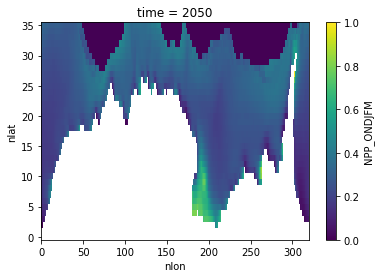

In [14]:
npp_scaled.isel(time=100).plot()

### Load Krill Growth Potential (KGP) data

In [15]:
path_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/marbl/'

In [16]:
# load KGP
file_in = 'CESM2-LE-seasonal-integrals-KGP.nc'
ds_kgp = xr.open_dataset(path_in+file_in, decode_times=True)

# use entire growth season
kgp = ds_kgp.KGP_ONDJFM

# set negative KGP to be zero, then mask land again
kgp = kgp.where(kgp > 0, other=0)
kgp = kgp.where(npp >= 0)

In [17]:
# keep only points in the SIZ by year and member
kgp_mask = kgp.where(ds_siz.SIZ_SEP == 1)

In [18]:
# get ensemble mean
kgp_mean = kgp_mask.mean(dim='member_id')

# replace missing values with 0
kgp_mean = kgp_mean.fillna(0)

In [19]:
# scale this yearly data by maximum value in whole domain
data = kgp_mean
scale_value = data.max(dim=['nlat','nlon'])
kgp_scaled = data/scale_value

# mask to omit land points
kgp_scaled = kgp_scaled.where(ds_grid.REGION_MASK == 1)

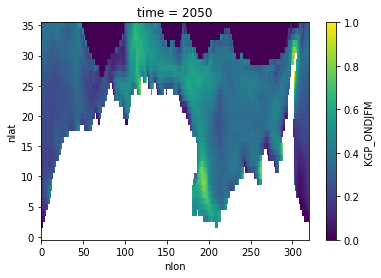

In [20]:
kgp_scaled.isel(time=100).plot()

### Load FEISTY fish data (use demersal fish layer only)

In [21]:
path_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/marbl/'

In [22]:
# load FEISTY
file_in = 'CESM2-LE-annual-mean-FEISTY.nc'
ds_feisty = xr.open_dataset(path_in+file_in, decode_times=True)

# use demersal only
demersal = ds_feisty.Demersal

In [23]:
# cut final year
demersal = demersal.where(demersal.time < 2100, drop=True)

In [24]:
# get ensemble mean
demersal_mean = demersal.mean(dim='member_id')

# replace missing values with 0
demersal_mean = demersal_mean.fillna(0)

In [25]:
# scale this yearly data by maximum value in whole domain
data = demersal_mean
scale_value = data.max(dim=['nlat','nlon'])
demersal_scaled = data/scale_value

# mask to omit land points
demersal_scaled = demersal_scaled.where(ds_grid.REGION_MASK == 1)

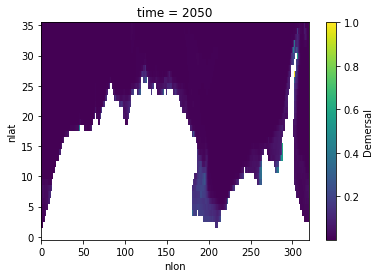

In [26]:
demersal_scaled.isel(time=100).plot()

### Load Emperor Penguin data

In [64]:
path_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/penguin/'

In [28]:
# load Emperor Penguin distances
file_in = 'CESM_grid_Emperor_individual_access_future.nc'
ds_ep = xr.open_dataset(path_in+file_in, decode_times=True)

total_ep = ds_ep.total_penguins

In [29]:
# cut years we don't need
total_ep = total_ep.where(total_ep.time >= 1950, drop=True)
total_ep = total_ep.where(total_ep.time < 2100, drop=True)

In [30]:
# scale this yearly data by maximum value in whole domain
data = total_ep
scale_value = data.max(dim=['nlat','nlon'])
ep_scaled = data/scale_value

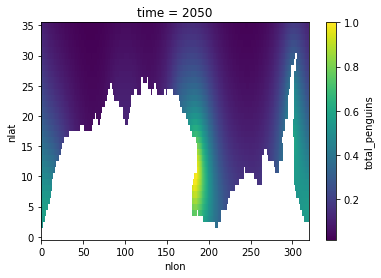

In [31]:
ep_scaled.isel(time=100).plot()

### Load Adelie Penguin data

In [32]:
path_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/penguin/'

In [33]:
# load Emperor Penguin distances
file_in = 'CESM_grid_Adelie_individual_access_future.nc'
ds_ap = xr.open_dataset(path_in+file_in, decode_times=True)

total_ap = ds_ap.total_penguins

In [34]:
# cut years we don't need
total_ap = total_ap.where(total_ap.time >= 1950, drop=True)
total_ap = total_ap.where(total_ap.time < 2100, drop=True)

In [35]:
# scale this yearly data by maximum value in whole domain
data = total_ap
scale_value = data.max(dim=['nlat','nlon'])
ap_scaled = data/scale_value

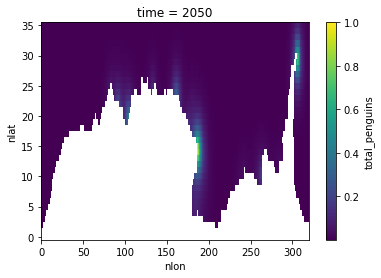

In [36]:
ap_scaled.isel(time=100).plot()

## Make Yearly ecoindex
- Calculate ecoindex by summing all inputs

In [37]:
# sum all inputs
ecoind_raw = npp_scaled + kgp_scaled + demersal_scaled + ep_scaled + ap_scaled

### Scale pan Antarctic

In [38]:
# scale this yearly data by maximum value in whole domain
scale_value = ecoind_raw.max(dim=['nlat','nlon'])
ecoind_hemispheric_yearly = ecoind_raw/scale_value

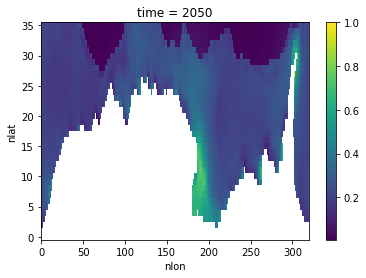

In [39]:
ecoind_hemispheric_yearly.isel(time=100).plot()

### Scale by region

In [40]:
## Scale ecoindex by maximum values in each CCAMLR region
data = ecoind_raw

# find the scale value by year and member and zone
scale_value_1 = data.where(ccamlr_masks.sel(region='mpa_plan_1_mod')==1).max(dim=['nlat','nlon'])
scale_value_3_4 = data.where(ccamlr_masks.sel(region='mpa_plan_3_4')==1).max(dim=['nlat','nlon'])
scale_value_7 = data.where(ccamlr_masks.sel(region='mpa_plan_7_mod')==1).max(dim=['nlat','nlon'])
scale_value_8 = data.where(ccamlr_masks.sel(region='mpa_plan_8')==1).max(dim=['nlat','nlon'])
scale_value_9 = data.where(ccamlr_masks.sel(region='mpa_plan_9')==1).max(dim=['nlat','nlon'])

# scale all values by year and member
var_scaled_1 = data.where(ccamlr_masks.sel(region='mpa_plan_1_mod')==1)/scale_value_1
var_scaled_3_4 = data.where(ccamlr_masks.sel(region='mpa_plan_3_4')==1)/scale_value_3_4
var_scaled_7 = data.where(ccamlr_masks.sel(region='mpa_plan_7_mod')==1)/scale_value_7
var_scaled_8 = data.where(ccamlr_masks.sel(region='mpa_plan_8')==1)/scale_value_8
var_scaled_9 = data.where(ccamlr_masks.sel(region='mpa_plan_9')==1)/scale_value_9

# replace missing values with 0
var_scaled_1 = var_scaled_1.fillna(0)
var_scaled_3_4 = var_scaled_3_4.fillna(0)
var_scaled_7 = var_scaled_7.fillna(0)
var_scaled_8 = var_scaled_8.fillna(0)
var_scaled_9 = var_scaled_9.fillna(0)

# sum all the ccamlr regions to get the eco index input
ecoind_regional_yearly = var_scaled_1+var_scaled_3_4+var_scaled_7+var_scaled_8+var_scaled_9

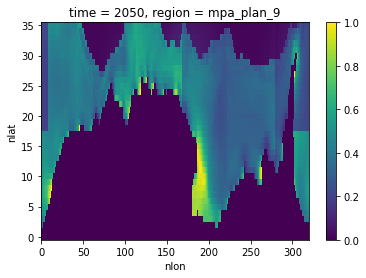

In [41]:
ecoind_regional_yearly.isel(time=100).plot()

## Make decadal means
- Calculate decadal index values by averaging 5 years around the decade (e.g. 1980 --> 1978, 1979, 1980, 1981, 1982)
- Want to do this because the penguin projections could be a little noisy (according to Stephanie Jenouvrier)

In [42]:
# specify some arrays that will become coordinate arrays
decades = list(range(1960,2100,10))
decade_names = ['1960','1970','1980','1990','2000','2010','2020','2030','2040','2050','2060','2070','2080','2090']

In [44]:
# get dimensions of the grid we need to iterate over
xlen = len(ecoind_raw.nlon)
ylen = len(ecoind_raw.nlat)
dlen = len(decades)
print(xlen,ylen,dlen)

320 36 14


In [49]:
# Loop through decades

# make numpy array to fill and specify dimensions
array_decadal_hemispheric = np.zeros([dlen,ylen,xlen])
array_decadal_regional = np.zeros([dlen,ylen,xlen])

for dec in decades:
    print('Calculating decadal means for '+str(dec)+'s')
    # need to specify which spot in the array we'll fill for the decade
    if dec == 1960:
        count = 0
    else: 
        count = count+1    
    # set the start and end years for this decade
    yy_st = dec - 2
    yy_ed = dec +3
    yy = list(range(yy_st,yy_ed,1)) 
    # subset the hemispheric data for these years only and get mean
    temp = ecoind_hemispheric_yearly.isel(time=ecoind_hemispheric_yearly.time.isin([yy]))
    array_decadal_hemispheric[count,:,:] = temp.mean(dim='time')
    # subset the hemispheric data for these years only and get mean
    temp = ecoind_regional_yearly.isel(time=ecoind_regional_yearly.time.isin([yy]))
    array_decadal_regional[count,:,:] = temp.mean(dim='time')

# convert to xarray
ecoind_hemispheric_decadal = xr.DataArray(array_decadal_hemispheric,dims=('decades','nlat','nlon'))
ecoind_hemispheric_decadal['decades'] = decades
ecoind_hemispheric_decadal['nlat'] = ecoind_raw.nlat
ecoind_hemispheric_decadal['nlon'] = ecoind_raw.nlon

ecoind_regional_decadal = xr.DataArray(array_decadal_regional,dims=('decades','nlat','nlon'))
ecoind_regional_decadal['decades'] = decades
ecoind_regional_decadal['nlat'] = ecoind_raw.nlat
ecoind_regional_decadal['nlon'] = ecoind_raw.nlon

Calculating decadal means for 1960s
Calculating decadal means for 1970s
Calculating decadal means for 1980s
Calculating decadal means for 1990s
Calculating decadal means for 2000s
Calculating decadal means for 2010s
Calculating decadal means for 2020s
Calculating decadal means for 2030s
Calculating decadal means for 2040s
Calculating decadal means for 2050s
Calculating decadal means for 2060s
Calculating decadal means for 2070s
Calculating decadal means for 2080s
Calculating decadal means for 2090s


## Save File

In [65]:
ds_out = xr.Dataset()

ds_out['ecoindex_regional_yearly'] = ecoind_regional_yearly
ds_out['ecoindex_regional_decadal'] = ecoind_regional_decadal
ds_out['ecoindex_hemispheric_yearly'] = ecoind_hemispheric_yearly
ds_out['ecoindex_hemispheric_decadal'] = ecoind_hemispheric_decadal

# change the attributes
ds_out.attrs['author'] = 'Alice DuVivier'
ds_out.attrs['date_processed'] = datetime.now().strftime('%Y-%m-%d')
ds_out.attrs['contents'] = f'Ecological Index - historical and future.'
ds_out.attrs['units'] = f'Unitless'

ds_out

<xarray.Dataset>
Dimensions:                       (nlat: 36, nlon: 320, time: 150, decades: 14)
Coordinates:
  * nlat                          (nlat) int64 0 1 2 3 4 5 ... 30 31 32 33 34 35
  * nlon                          (nlon) int64 0 1 2 3 4 ... 315 316 317 318 319
  * time                          (time) int64 1950 1951 1952 ... 2097 2098 2099
    TLONG                         (nlat, nlon) float64 320.6 321.7 ... 319.4
    TLAT                          (nlat, nlon) float64 -79.22 -79.22 ... -60.52
    ULONG                         (nlat, nlon) float64 321.1 322.3 ... 320.0
    ULAT                          (nlat, nlon) float64 -78.95 -78.95 ... -60.25
    region                        <U14 'mpa_plan_9'
  * decades                       (decades) int64 1960 1970 1980 ... 2080 2090
Data variables:
    ecoindex_regional_yearly      (time, nlat, nlon) float64 dask.array<chunksize=(150, 36, 320), meta=np.ndarray>
    ecoindex_regional_decadal     (decades, nlat, nlon) float64 0.0 ... 0.1759
    ecoindex_hemispheric_yearly   (time, nlat, nlon) float64 dask.array<chunksize=(150, 36, 320), meta=np.ndarray>
    ecoindex_hemispheric_decadal  (decades, nlat, nlon) float64 nan ... 0.1759
Attributes:
    author:          Alice DuVivier
    date_processed:  2024-10-11
    contents:        Ecological Index - historical and future.
    units:           Unitless

In [66]:
# drop unnecessary coordinates
ds_out = ds_out.drop('region')
ds_out = ds_out.drop('ULAT')
ds_out = ds_out.drop('ULONG')

In [67]:
ds_out

<xarray.Dataset>
Dimensions:                       (nlat: 36, nlon: 320, time: 150, decades: 14)
Coordinates:
  * nlat                          (nlat) int64 0 1 2 3 4 5 ... 30 31 32 33 34 35
  * nlon                          (nlon) int64 0 1 2 3 4 ... 315 316 317 318 319
  * time                          (time) int64 1950 1951 1952 ... 2097 2098 2099
    TLONG                         (nlat, nlon) float64 320.6 321.7 ... 319.4
    TLAT                          (nlat, nlon) float64 -79.22 -79.22 ... -60.52
  * decades                       (decades) int64 1960 1970 1980 ... 2080 2090
Data variables:
    ecoindex_regional_yearly      (time, nlat, nlon) float64 dask.array<chunksize=(150, 36, 320), meta=np.ndarray>
    ecoindex_regional_decadal     (decades, nlat, nlon) float64 0.0 ... 0.1759
    ecoindex_hemispheric_yearly   (time, nlat, nlon) float64 dask.array<chunksize=(150, 36, 320), meta=np.ndarray>
    ecoindex_hemispheric_decadal  (decades, nlat, nlon) float64 nan ... 0.1759
Attributes:
    author:          Alice DuVivier
    date_processed:  2024-10-11
    contents:        Ecological Index - historical and future.
    units:           Unitless

In [68]:
# Print the dimensions
print("Dimensions:")
for dim in ds_out.dims:
    print(f"\t{dim}: {ds_out[dim].values.shape}")

# Print the coordinates
print("Coordinates:")
for coord in ds_out.coords:
    print(f"\t{coord}:")
    print(f"\t\t{ds_out.coords[coord].values}")
    
# Print the attributes
print("Attributes:")
for attr in ds_out.attrs:
    print(f"\t{attr}: {ds_out.attrs[attr]}")

Dimensions:
	nlat: (36,)
	nlon: (320,)
	time: (150,)
	decades: (14,)
Coordinates:
	nlat:
		[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
	nlon:
		[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 19

In [69]:
# calculate the size of the dataset in GB
size_gb = ds_out.nbytes / (1024**3)
print(f"The dataset is approximately {size_gb:.2f} GB.")


The dataset is approximately 0.03 GB.


In [70]:
path_out = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/ecoindex/'
file_out = 'ecoindex_historical_future.nc'
fout = path_out + file_out

In [71]:
# Export the dataset to NetCDF with all attributes and coordinates
ds_out.to_netcdf(fout)